# Dataset exploration - MIT BIH

# Imports

In [2]:
# install all imports (also later ones) on the jupyter notebook silently if necessary, but check if already installed
# import sys
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install --upgrade numpy pandas matplotlib seaborn scikit-learn imblearn
# !{sys.executable} -m pip install --upgrade jupyter
# !{sys.executable} -m pip install --upgrade jax wfdb scienceplots optax


In [3]:
# native Python waveform-database (WFDB) package
# A library of tools for reading, writing, and processing 
# WFDB signals and annotations
import wfdb 
import os
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import jax 
import jax.numpy as jnp
import optax
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample

plt.style.use(['science', 'notebook', 'grid'])
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".50"

In [4]:
# check if the dataset 'mit-bih-arrhythmia-database-1.0.0' exists in the current directory
if not os.path.isdir('mit-bih-arrhythmia-database-1.0.0'):
    # download the dataset from Physionet
    print('Missing data in the current directory')
    # check if the dataset is in the parent directory
    if os.path.isdir('../mit-bih-arrhythmia-database-1.0.0'):
        print('Data found in the parent directory')
        data_dir = '../mit-bih-arrhythmia-database-1.0.0'
    else: 
        print('Missing data in the parent directory')

Missing data in the current directory
Data found in the parent directory


# Full dataset

In [5]:
# read from the folder all the records number
records = []
symbols = []
samples = []
patient_ids = []
for patient_id in os.listdir(data_dir):
    if not patient_id.endswith('.atr'):
        continue
    pid = patient_id.split('.')[0]
    if pid == '102-0':
        continue
    record = wfdb.rdrecord(os.path.join(data_dir, pid))
    annotation = wfdb.rdann(os.path.join(data_dir, pid), 'atr')
    records.append(record.p_signal)
    symbols.append(np.array(annotation.symbol))
    samples.append(annotation.sample)
    patient_ids.append(int(pid))
print(f'Number of patients: {len(patient_ids)}')
print(f'Patient ids: {patient_ids}')


Number of patients: 48
Patient ids: [118, 124, 119, 122, 123, 121, 109, 108, 219, 231, 230, 232, 233, 223, 222, 220, 234, 208, 209, 221, 210, 205, 213, 207, 212, 202, 203, 217, 201, 215, 228, 214, 200, 111, 105, 104, 106, 112, 113, 107, 103, 117, 116, 102, 114, 100, 101, 115]


In [6]:
# sort the patient ids in ascending order 
patient_ids = np.array(patient_ids, dtype=np.uint8)
argsort_ids = np.argsort(patient_ids)
patient_ids_sort = patient_ids[argsort_ids]
records_sort = np.array(records)[argsort_ids]
symbols_sort = [] ; samples_sort = [] # can't use np.array() because the length of each item is different
for i in range(len(symbols)):
    symbols_sort.append(symbols[argsort_ids[i]])
    samples_sort.append(samples[argsort_ids[i]])

In [7]:
# Make sure that the records are sorted correctly
print(f'patient_ids_sort[0]: {patient_ids_sort[0]} - recovered in position: {argsort_ids[0]}')
print(np.array_equal(records_sort[0], records[argsort_ids[0]]))
print(np.array_equal(symbols_sort[0], symbols[argsort_ids[0]]))
print(np.array_equal(samples_sort[0], samples[argsort_ids[0]]))

for i in range(48):
    assert np.array_equal(records_sort[i], records[argsort_ids[i]]), f'Records: Not equal for patient_ids_sort[{i}] - recovered in position: {argsort_ids[i]}'
    assert np.array_equal(symbols_sort[i], symbols[argsort_ids[i]]), f'Symbols: Not equal for patient_ids_sort[{i}] - recovered in position: {argsort_ids[i]}'
    assert np.array_equal(samples_sort[i], samples[argsort_ids[i]]), f'Samples: Not equal for patient_ids_sort[{i}] - recovered in position: {argsort_ids[i]}'

patient_ids_sort[0]: 100 - recovered in position: 45
True
True
True


In [8]:
# TODO 1: make the dataset multi-class

Xs = [] ; ys = []
classes = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'U']
nb_removed = np.zeros(48)
hr_factor = (650000/(360 * 60))**(-1)
hr_patients = np.zeros(48)
smaller_ipi = np.zeros(48) # smaller inter-pulse interval
classes_repartition = np.zeros((48, 5))
for i in range(48): # for every patient
    len_samples = len(samples_sort[i])
    samples_sort[i] = samples_sort[i][np.in1d(symbols_sort[i], classes)] # select only the samples corresponding to the desired classes
    symbols_sort[i] = symbols_sort[i][np.in1d(symbols_sort[i], classes)] # select only the symbols corresponding to the desired classes
    nb_removed[i] = len_samples - len(samples_sort[i]) # compute the number of removed samples from the selection process
    hr_patients[i] = len(samples_sort[i])*hr_factor    # compute the heart rate 
    smaller_ipi[i] = np.min(np.diff(samples_sort[i]))  # compute the smallest inter-pulse interval

    # TODO 1.1: replace the symbols with the corresponding class 
    # NOTE: class 0 = ['N', 'L', 'R', 'e', 'j']
    #       class 1 = ['A', 'a', 'J', 'S']
    #       class 2 = ['V', 'E']
    #       class 3 = ['F']
    #       class 4 = ['/', 'f', 'U']
    # replace the symbols with the corresponding class

    
    # compute the classes repartition
    values, counts = np.unique(symbols_sort[i], return_counts=True)
    for j in range(len(values)):
        classes_repartition[i, values[j]] = counts[j]

In [9]:
Xs = [] ; ys = [] ; pids = []
X_208s = []; y_208s = []; pids_208s = []

safe_half_window = int(np.min(smaller_ipi)*0.8)

for i in range(48):
    X = np.zeros((len(samples_sort[i])-2, 2*safe_half_window)) # -2 because the first and last R peaks have shorter windows
    y = np.zeros(len(samples_sort[i])-2)
    for j, s in enumerate(samples_sort[i][1:-1]):
        X[j, :] = records_sort[i][s-safe_half_window:s+safe_half_window, 0] 
        y[j] = symbols_sort[i][j]
    # add to general dataset
    Xs.append(X)
    ys.append(y)
    pids.append(np.ones(len(y), dtype=np.uint8)*patient_ids_sort[i])

    if patient_ids_sort[i] == 208:
        X_208s.append(X)
        y_208s.append(y)
        pids_208s = np.ones(len(y), dtype=np.uint8)*patient_ids_sort[i]

In [10]:
# concatenate the data
X = np.concatenate(Xs, axis=0)
y = np.concatenate(ys, axis=0).astype(np.int8)
pids = np.concatenate(pids, axis=0).astype(np.uint8)

# PATIENT 208
X_208 = np.concatenate(X_208s, axis=0)
y_208 = np.concatenate(y_208s, axis=0).astype(np.int8)

print(f'X.shape: {X.shape} - y.shape: {y.shape} - pids.shape: {pids.shape}')
print(f'X_208.shape: {X_208.shape} - y_208.shape: {y_208.shape}')

X.shape: (109365, 144) - y.shape: (109365,) - pids.shape: (109365,)
X_208.shape: (2951, 144) - y_208.shape: (2951,)


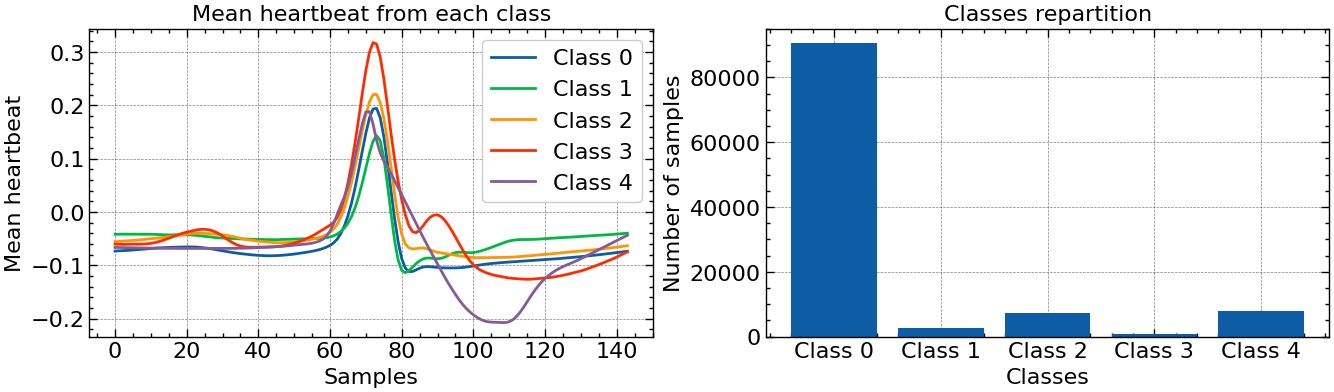

In [18]:
# TODO 2: plot the mean heartbeat from each class and plot the classes repartition using only X and y
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
# TODO 2.1: plot the mean heartbeat from each class in ax[0]

# TODO 2.2: plot the classes repartition in ax[1]

plt.show()

## Normalization

In [12]:
# X (full dataset)
X_max = np.max(X, axis=0)
X_norm = X / X_max

# PATIENT 208
X_208_norm = X_208 / X_max

# always use normalize data
X = X_norm
X_208 = X_208_norm


## Balancing

In [13]:
# get class distribution of patient 208
class_dist_208 = np.bincount(y_208)
print(f'Class distribution of patient 208: {class_dist_208}')
# remove class 1 as there are not sufficiently enough samples
X_208 = X_208[y_208 != 1]
y_208 = y_208[y_208 != 1]

Class distribution of patient 208: [1584    2  992  373]


In [1]:
# TODO 3: Try to balance the dataset using random undersampling and resampling from sklearn
# NOTE: the solution downsamples class 0 to match the number of samples in class 2
#       and then resamples (upsamples) class 3 to match the number of samples in class 2

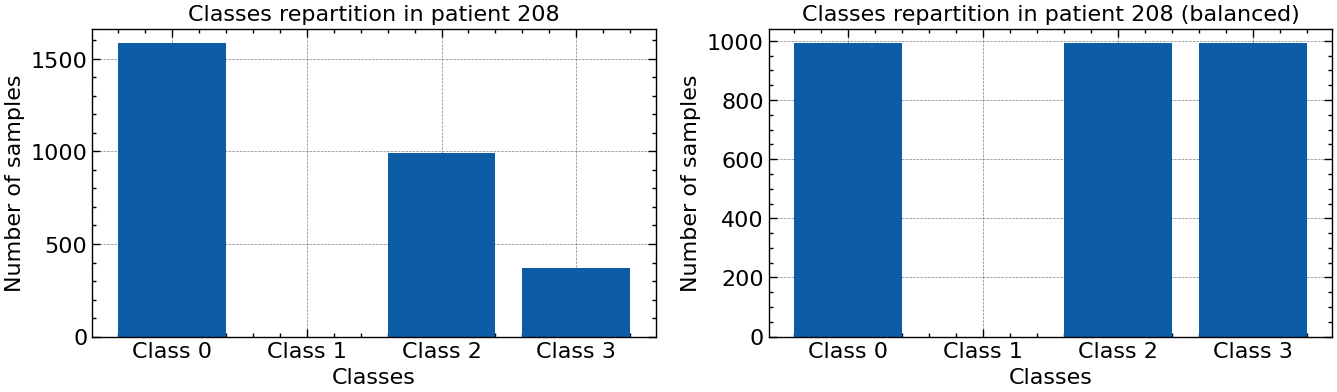

In [25]:
# TODO 4: plot class distribution before and after balancing
num_classes = len(np.unique(y_208))
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
# TODO 4.1: plot the classes repartition in patient 208 before balancement in ax[0]

# TODO 4.2: plot the classes repartition in patient 208 after balancement in ax[1]

plt.show()

## Encoding

### Delta Modulation

In [22]:
# from snntorch tutorial 1
def delta_fn(data, threshold=0.000):
    pos_ch = np.heaviside(np.diff(data)-threshold, 0)
    neg_ch = np.heaviside(-np.diff(data)-threshold, 0)
    return (pos_ch, neg_ch) # 2 channels for positive and negative spikes

### Encode the dataset

In [23]:
thr_X = 0.000

# regular dataset
X_spike = delta_fn(X_norm, threshold=thr_X)

# balanced dataset
#Xbalanced_spike = delta_fn(X_balanced, threshold=thr_X)

# PATIENT 208
X_208_spike = delta_fn(X_208_norm, threshold=thr_X)


#print(Xbalanced_spike[0].shape)

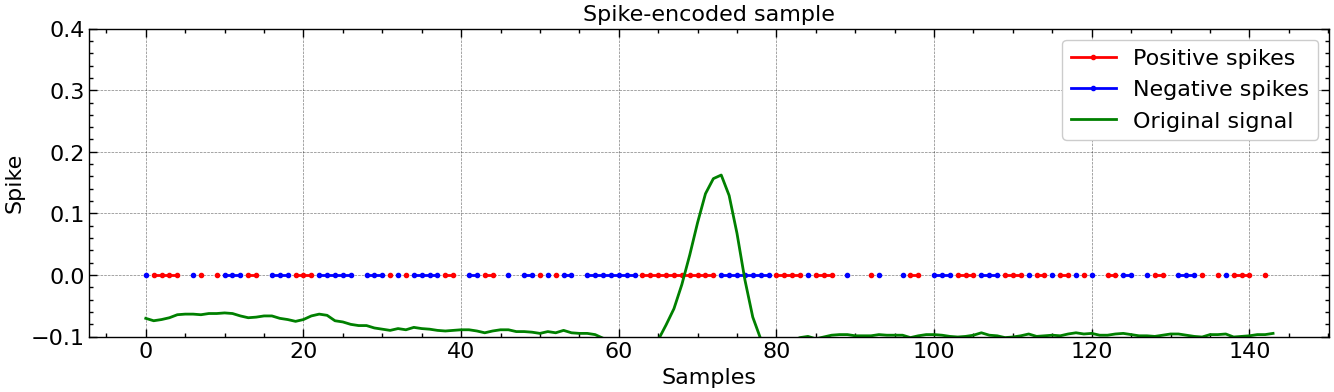

In [24]:
# plot one spike-encoded sample
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
id_sample = 30
pos_ch = X_spike[0][id_sample]
neg_ch = X_spike[1][id_sample]
# replace 0 with nan
pos_ch[pos_ch==0] = np.nan
neg_ch[neg_ch==0] = np.nan
# replace 1 with 0 for neg channel
neg_ch[neg_ch==1] = 0
pos_ch[pos_ch==1] = 0
ax.plot(pos_ch, label='Positive spikes', color='r', marker='o', markersize=3)
ax.plot(neg_ch, label='Negative spikes', color='b', marker='o', markersize=3)
# plot the original signal
ax.plot(X_norm[id_sample], label='Original signal', color='g')
# set y range to -0.1 to 1.1
ax.set_ylim(-0.1, 0.4)
ax.set_xlabel('Samples')
ax.set_ylabel('Spike')
ax.set_title('Spike-encoded sample')
ax.legend()
plt.show()
